In [18]:
import sys

from scipy.optimize import curve_fit

sys.path.append("../../src")

from relaxnmr.core import T1Functions

import numpy as np

import matplotlib.pyplot as plt

In [19]:
filepath = r"..\..\data\T1_rho_data\79\\"

t1 = T1Functions(filepath)

In [20]:
spectra, vd_list, csdm_ds = t1.read_and_convert_bruker_data(filepath)

In [21]:
#process each spectrum in the saved spectra and save spectra as exp_spectra

exp_spectra = []
for i, spectrum in enumerate(spectra):
    if i < 4:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-10, ph1=0)
        exp_spectra.append(exp_spectrum)
    # elif i == 2:
    #     exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-10, ph1=0)
    #     exp_spectra.append(exp_spectrum)
    elif 4 >= i <= 7:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=15, ph0=5, ph1=0)
        exp_spectra.append(exp_spectrum)
    # elif 8 >= i <=9:
    #     exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-10, ph1=0)
    #     exp_spectra.append(exp_spectrum)

    # if 10 <= i <= 11:
    #     exp_spectrum = process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=90, ph1=0.55)
    #     exp_spectra.append(exp_spectrum)
    # elif 12 <= i <= 17:
    #     exp_spectrum = process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=70, ph1=0.55)
    #     exp_spectra.append(exp_spectrum)
    # else:
    # if i == 14:
    else:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1000 Hz", zero_fill_factor=10, ph0=15, ph1=0)
        exp_spectra.append(exp_spectrum)

In [22]:
#integrate ppm region of interest in each spectrum using "integrate_spectrum_region" function

"""The integration function employed here integrate each spectrum using trapezoid and simpson function, respectively.
ppm_start and ppm_end need to be defined as the starting and ending ppm region needed to be integrated. 
The integrated area of each spectrum is appended to trapz_ints and simps_ints, respectively.
x_ and y_regions are regions of integration in the spectra -- needed for visuals"""

trapz_ints = []
simps_ints = []
x_regions = []
y_regions = []
int_uncs = []
for i, exp_spectrum in enumerate(exp_spectra):
    trapz_int, simps_int, x_region, y_region, int_unc = t1.integrate_spectrum_region(exp_spectrum, ppm_start=-200, ppm_end=200)
    trapz_ints.append(trapz_int)
    simps_ints.append(simps_int)
    x_regions.append(x_region)
    y_regions.append(y_region)
    int_uncs.append(int_unc)

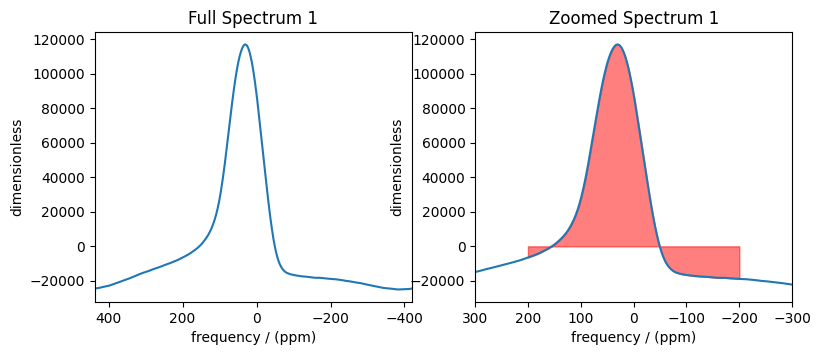

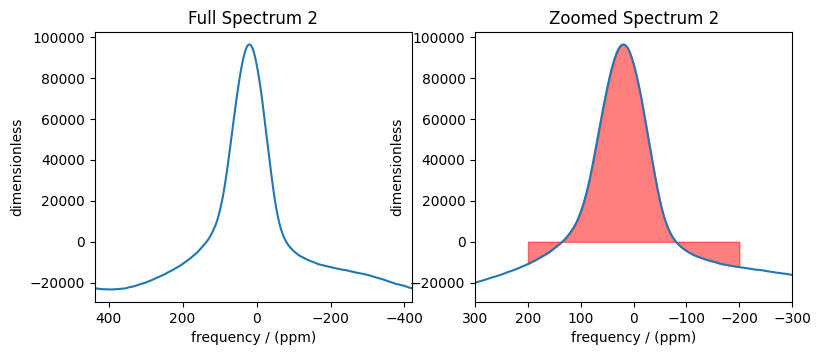

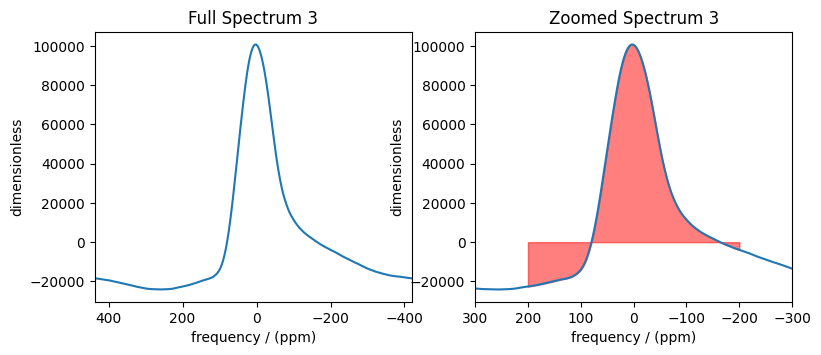

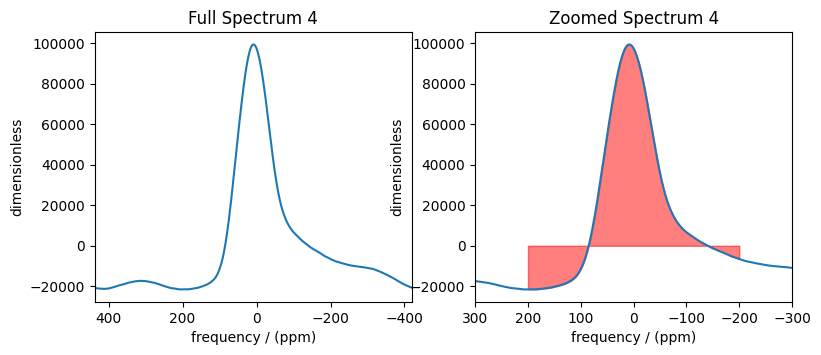

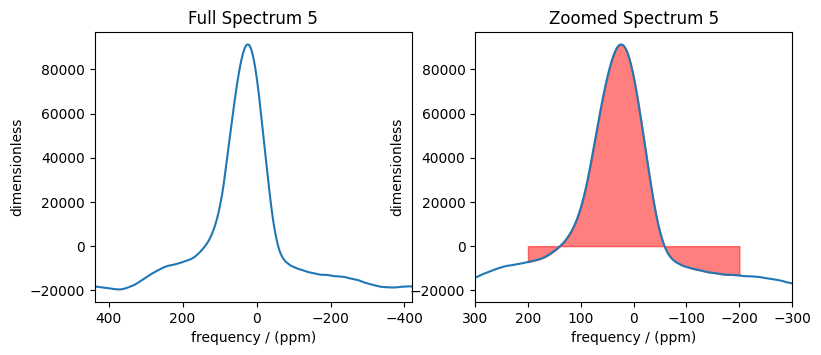

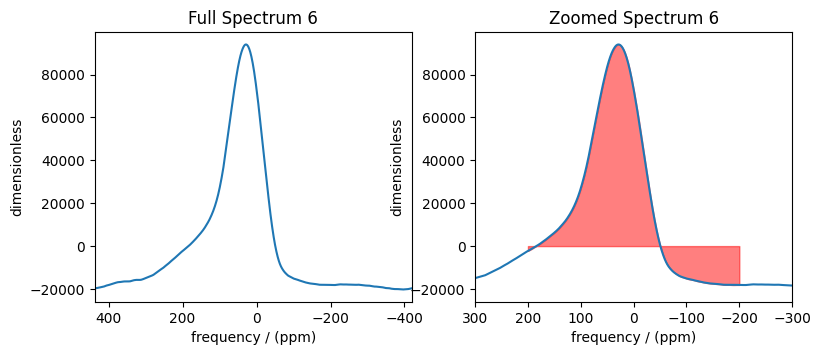

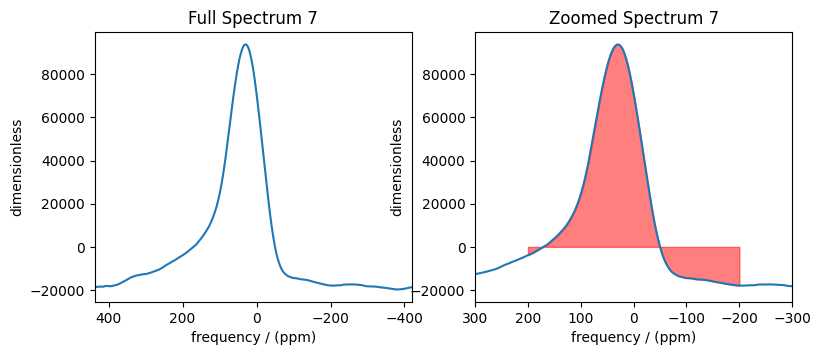

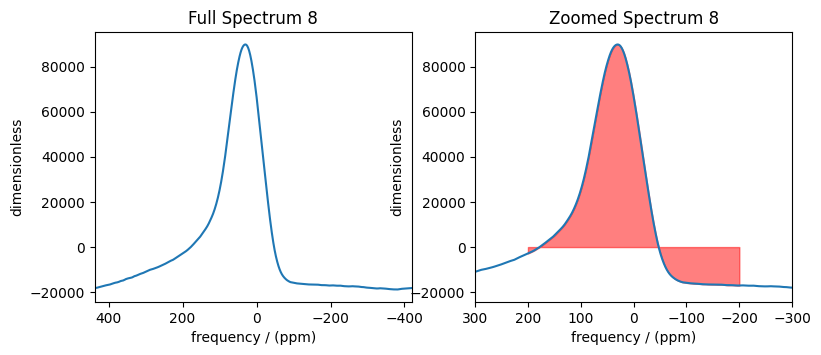

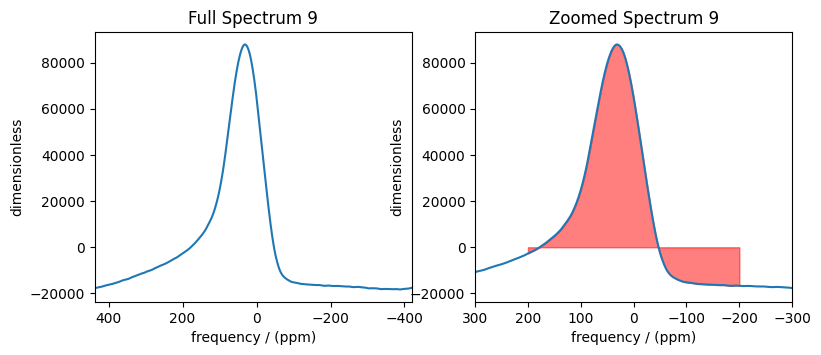

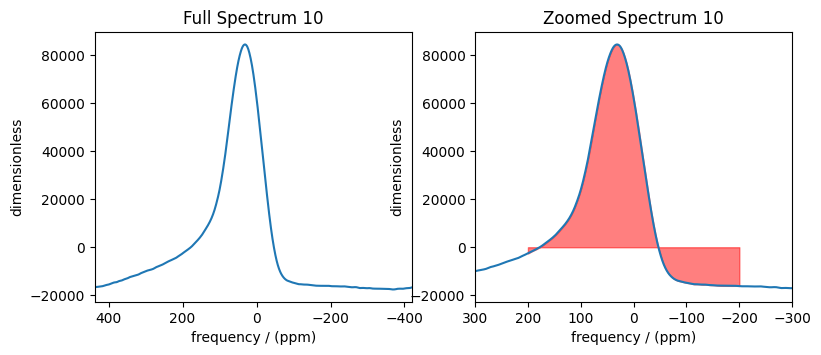

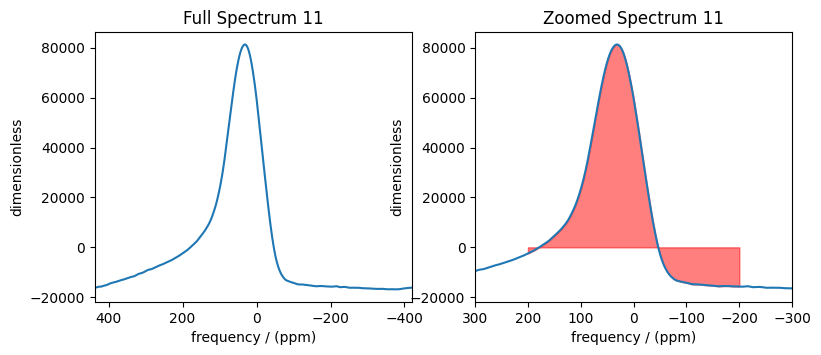

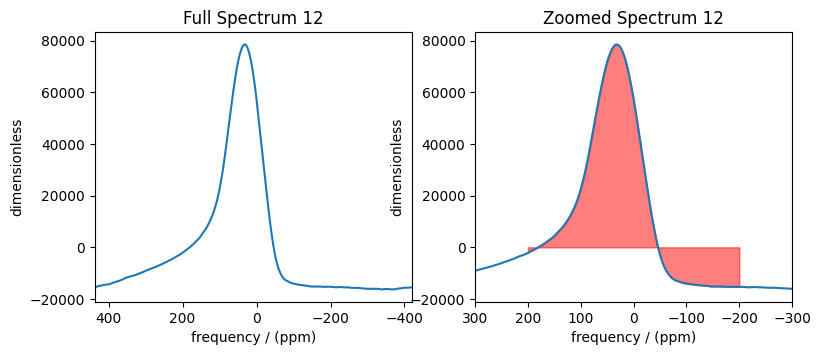

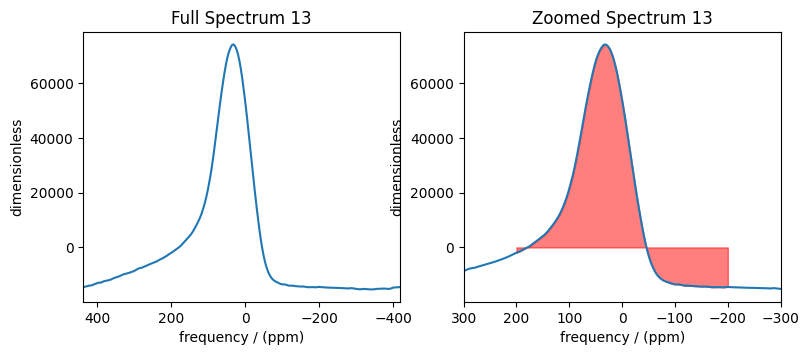

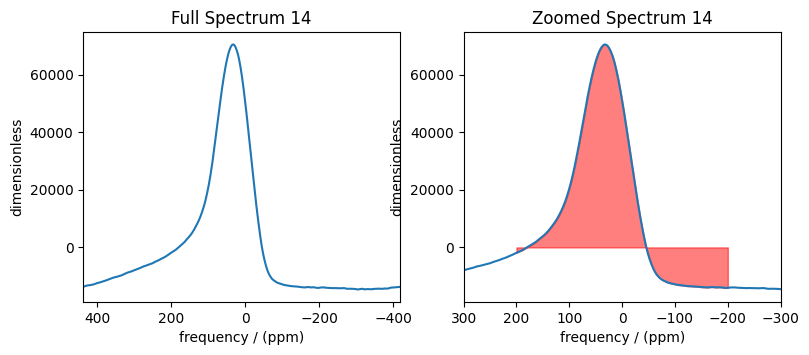

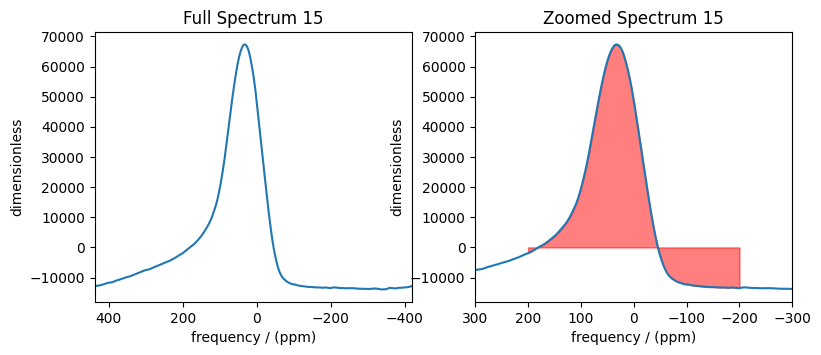

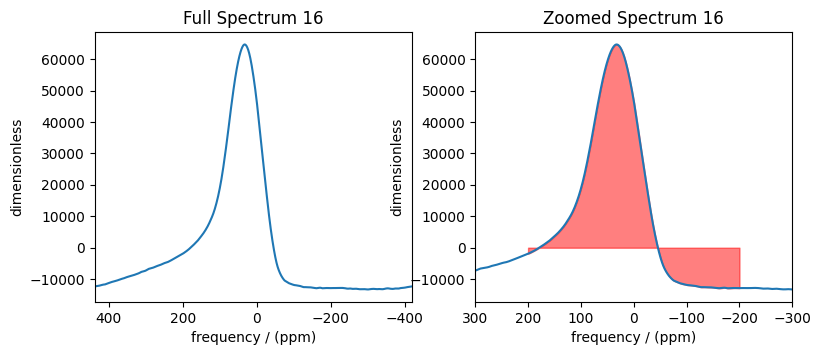

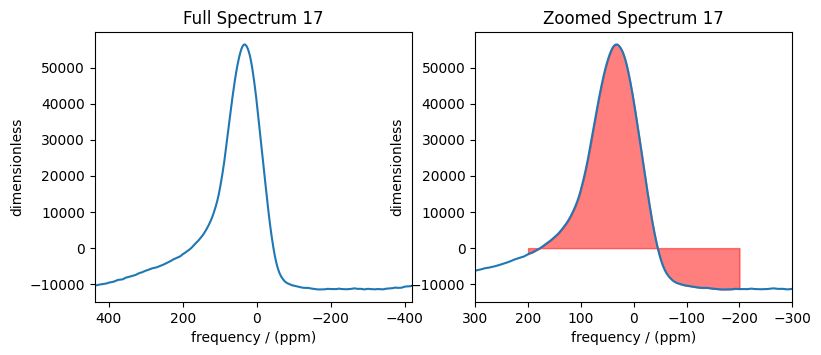

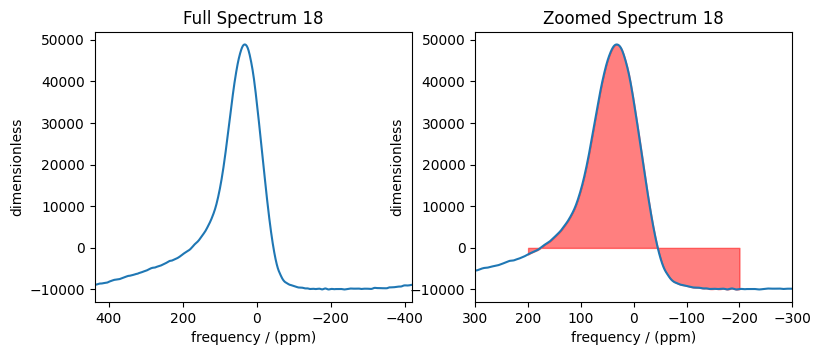

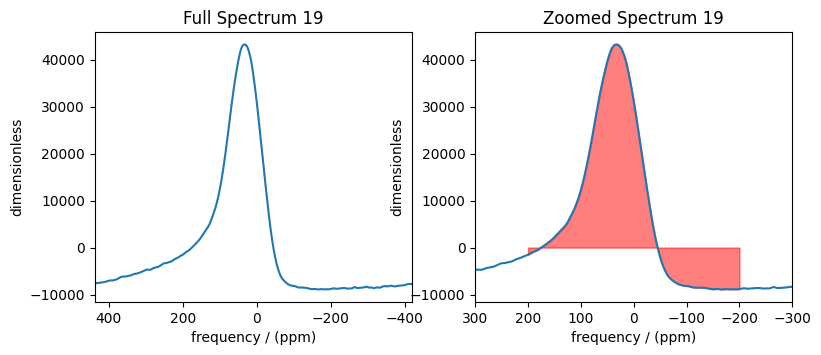

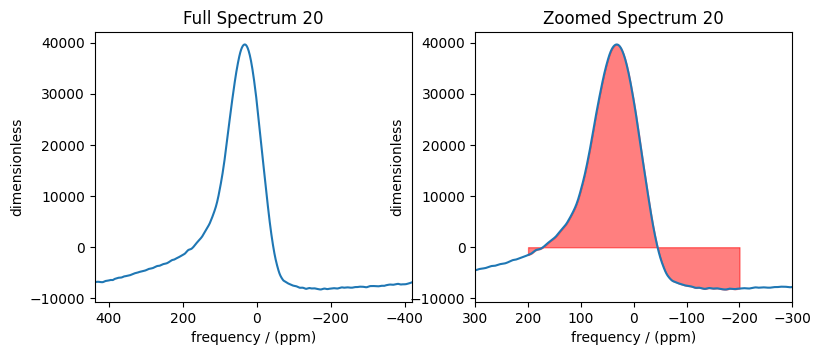

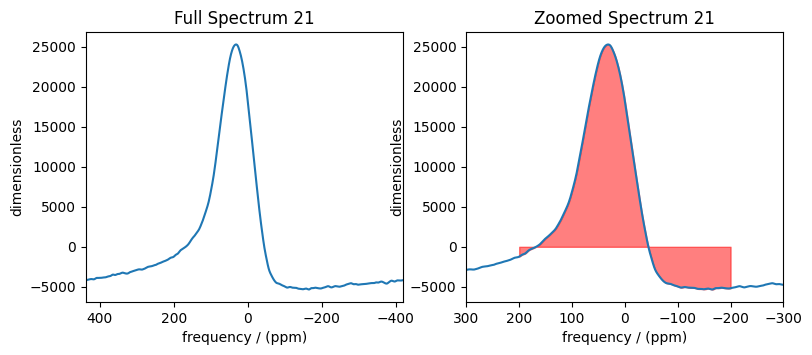

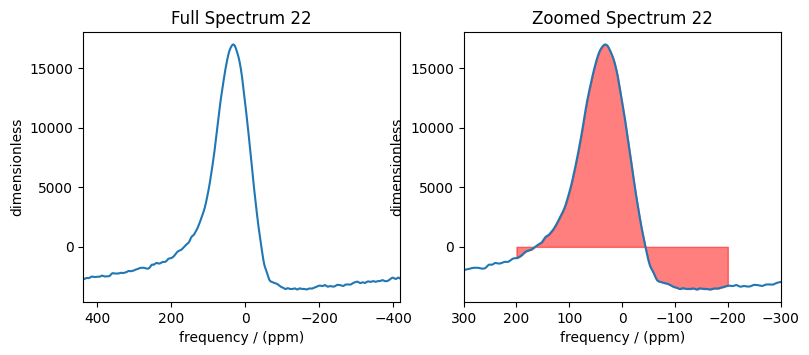

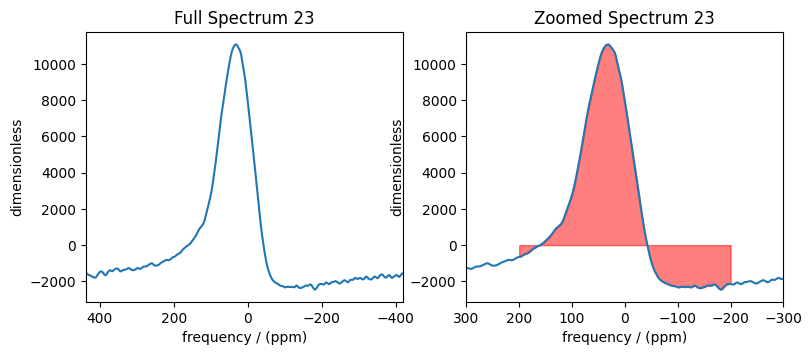

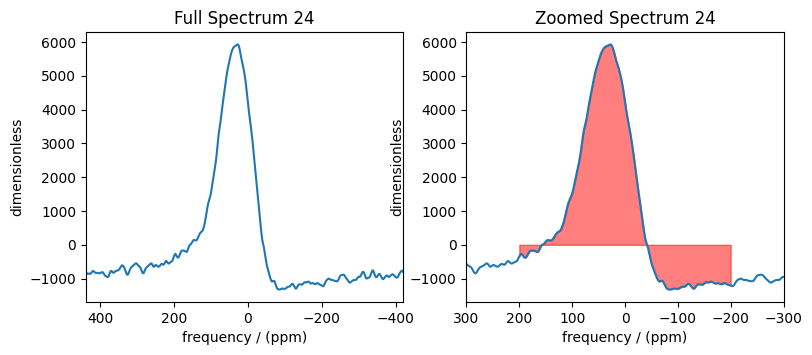

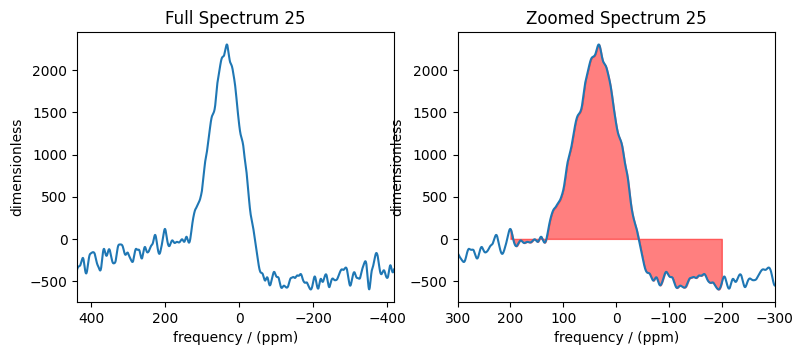

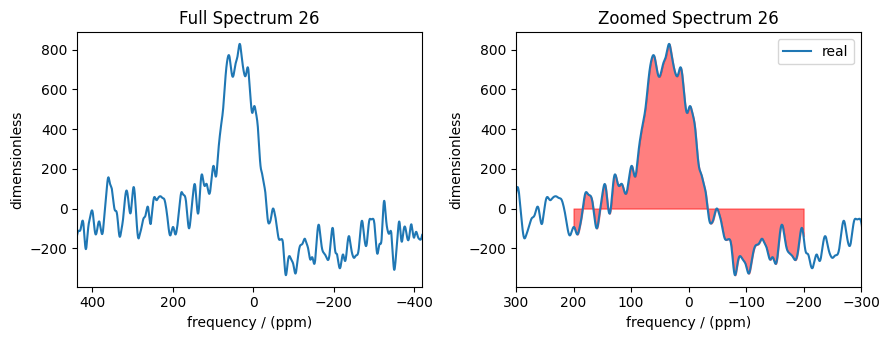

In [23]:
abs_ints = t1.plot_spectra_and_zoomed_regions(exp_spectra, x_regions, y_regions, 300, -300)

In [24]:
#vd_list imported from the file_path and converted into a numpy array

vd_list = np.array(vd_list)

# print(len(vd_list))
# # slicing the vd_list if some data points are shitty
vd_list = vd_list[:len(abs_ints)]
# 

vd_list = vd_list

print(len(vd_list))

26


In [25]:
# # slicing the intensities if some data points are shitty

simps_ints = simps_ints[:len(vd_list)]

abs_ints = abs_ints[:len(vd_list)]
print(len(abs_ints))

26


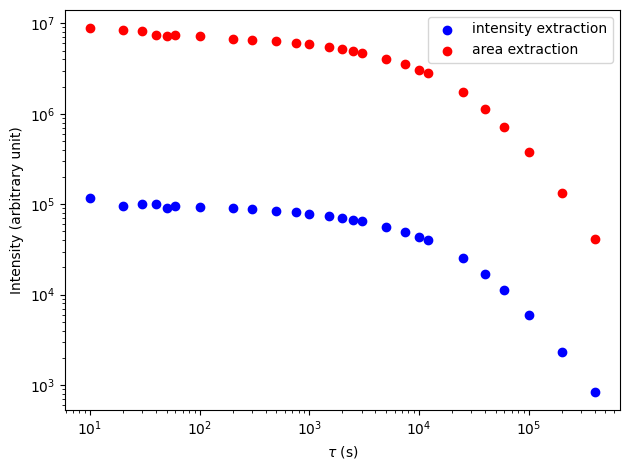

In [26]:
fig, ax = plt.subplots()

ax.scatter(vd_list, abs_ints, color='blue', label='intensity extraction')


ax.scatter(vd_list, simps_ints, color='red', label='area extraction')
# ax.errorbar(vd_list, simps_ints, yerr=int_uncs, fmt='o', color='red', label='error')

ax.semilogy()

ax.semilogx()

ax.legend(loc='best', frameon=True)

ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')



plt.tight_layout()

plt.show()

T1_simps_area: 2662.669380158095 ± 420.3354247017269
T2_simps_area: 31749.859170008207 ± 2959.941856228142
T3_simps_area: 32.54706003128864 ± 5.294751124532547
A_simps_area: 9752113.380311077 ± 3331619624905.6206
C_simps_area: 0.2860903140053647 ± 97903.89402454725
D_simps_area: 0.42441289393296355 ± 145242.16674204214
E_simps_area: 0.2728095029620312 ± 93359.86653125039
0.9833127109003595


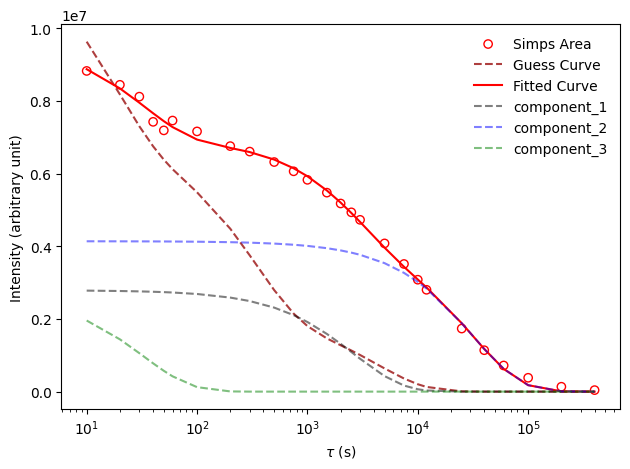

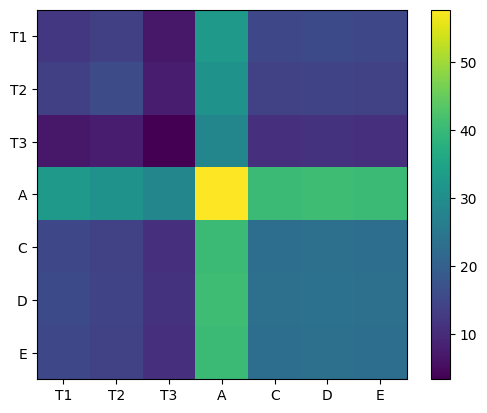

<Figure size 640x480 with 0 Axes>

In [27]:
#T1rho fitting

fig, ax = plt.subplots()
output_lines = []
# Define a list of tuples for the two sets of intensities
intensity_sets = [
    (simps_ints, 'Simps Area', 'Guess Curve', 'Fitted Curve', 'r'),
    (abs_ints, 'Absolute Intensities', 'Guess Abs Int Curve', 'Fitted Curve Absolute Intensity', 'b')
]


# Initial guess parameters

T1_guess = 320.7

T2_guess = 4378.2

T3_guess = 17.4



for i, (ints, label, guess_label, fitted_label, color) in enumerate(intensity_sets):
    if i ==0:
        # A_guess = np.max(ints)
        A_guess = 1e7
        
        B_guess = np.min(ints)
        
        C_guess = 0.48
        
        D_guess = 0.2
        
        E_guess = 0.53
        
    
    # Scatter plot
        # ax.scatter(vd_list, ints, color=color, label=label)
    #scatter plot with marker having no face color
        ax.scatter(vd_list, ints, color=color, marker='o', facecolors='none', label=label)
    
    # Guess curve
        guess_integrated_int = t1.tri_expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, C_guess, D_guess, E_guess)
        # guess_integrated_int = t1.expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, B_guess)
        
        ax.plot(vd_list, guess_integrated_int, color='brown', linestyle='--', label=guess_label, alpha=0.9)
    
    # Fit the data
        popt, pcov = curve_fit(t1.tri_expdec, vd_list, ints, p0=[T1_guess, T2_guess, T3_guess, A_guess, C_guess, D_guess, E_guess])
    
    # Save the fitted params and uncertainties
        T1_fitted, T2_fitted, T3_fitted, A_fitted, C_fitted, D_fitted, E_fitted = popt
        T1_unc, T2_unc, T3_unc, A_unc, C_unc, D_unc, E_unc = np.sqrt(np.diag(pcov))
        
        #define T1 and T2
        component_1 = A_fitted *  (C_fitted)*np.exp(-vd_list/T1_fitted)
        
        component_2 = A_fitted * (D_fitted)*np.exp(-vd_list/T2_fitted)
        
        component_3 = A_fitted * (E_fitted)*np.exp(-vd_list/T3_fitted) 
        
        overall_component = component_1 + component_2 + component_3
    
    # Extract the fitted curve
        fitted_curve = t1.tri_expdec(vd_list,T1_fitted, T2_fitted, T3_fitted, A_fitted, C_fitted, D_fitted, E_fitted)
        ax.plot(vd_list, fitted_curve, linestyle='-', color=color, label=fitted_label)
        # ax.scatter(vd_list, fitted_curve, color='black', marker='o', facecolors='none', label=fitted_label)
        ax.plot(vd_list, component_1, linestyle='--', color='black', alpha=0.5, label='component_1')
        ax.plot(vd_list, component_2, linestyle='--', color='blue', alpha=0.5, label='component_2')
        ax.plot(vd_list, component_3, linestyle='--', color='green', alpha=0.5, label='component_3')
        # ax.plot(vd_list, overall_component, linestyle='--', color='red', alpha=0.5, label='overall_component')
    
    # print the fitted parameters and uncertainties
        print(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}')
        print(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}')
        print(f'T3_{label.lower().replace(" ", "_")}: {T3_fitted} ± {T3_unc}')
        print(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}')
        # print(f'B_{label.lower().replace(" ", "_")}: {B_fitted} ± {B_unc}')
        print(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}')
        print(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}')
        print(f'E_{label.lower().replace(" ", "_")}: {E_fitted} ± {E_unc}')
        print(E_fitted+C_fitted+D_fitted)
    
    
    # #Format the string and append fitted parameters
        
        output_lines.append(f'M0_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}\n')
        output_lines.append(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}\n')
        output_lines.append(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}\n')
        output_lines.append(f'T3_{label.lower().replace(" ", "_")}: {T3_fitted} ± {T3_unc}\n')
        output_lines.append(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}\n')
        output_lines.append(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}\n')
        output_lines.append(f'E_{label.lower().replace(" ", "_")}: {E_fitted} ± {E_unc}\n')
        #save the fitted params and uncertainties in a text file
        with open(filepath+'multi_exp_fitted_params.txt', 'w') as f:
            f.writelines(output_lines)


# ax.semilogy()
ax.semilogx()
ax.legend(loc='best', frameon=False)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')


#plot the covariance matrix in another figure and label the axes with the fitted parameters


plt.savefig(filepath+'multi_exp_T1_fitting.svg', bbox_inches='tight', transparent=True)
plt.tight_layout()
fig, ax = plt.subplots()
im = ax.imshow(np.log(np.abs(pcov)))
ax.set_xticks(np.arange(len(popt)))
ax.set_yticks(np.arange(len(popt)))
ax.set_xticklabels(['T1', 'T2', 'T3', 'A', 'C', 'D', 'E'])
ax.set_yticklabels(['T1', 'T2', 'T3', 'A', 'C', 'D', 'E'])
plt.colorbar(im)
plt.show()
plt.clf()